## CNN Classifier Testscript - Vacation Images
This version has already resized images in the datafolders to avoid a bottleneck while training the network.


### Imports

In [1]:
#general
import numpy as np
import splitfolders
import time
from datetime import datetime 
from time import gmtime, strftime
from tqdm import tqdm
import os

#pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

#visualization
import matplotlib.pyplot as plt

### Some parameters to be set

In [2]:
#==============#
pixel = 128    # --> 128,64,32 are valid
#==============#
version = f'{pixel}x{pixel}'
#==============#
batch_size = 32
#==============#
epochs = 300
#==============#
lr = 0.001
#==============#
momentum = 0.9
#==============#
num_workers = 4
#==============#

### Script Runtime Start

In [3]:
def start_time_():    
    start_time = time.time()
    return(start_time)

def end_time_():
    end_time = time.time()
    return(end_time)

def Execution_time(start_time_,end_time_):
    return(strftime("%H:%M:%S",gmtime(int('{:.0f}'.format(float(str((end_time_-start_time_))))))))

In [4]:
script_start = start_time_()

### Create Directory for saving files

In [5]:
dirName_1 = f'graphs/{version}'
dirName_2 = f'models/{version}'
dirName_3 = f'output_txt/{version}'

directories = [dirName_1, dirName_2, dirName_3]

# Create target Directory if don't exist

for path in directories:
    if not os.path.exists(path):
        os.mkdir(path)
        print("Directory " , path ,  " Created ")
    else:    
        print("Directory " , path ,  " already exists")  

Directory  graphs/128x128  already exists
Directory  models/128x128  already exists
Directory  output_txt/128x128  already exists


### Initialize textfile for prints

In [6]:
f = open(f'output_txt/{version}/cnn_net_b{batch_size}_e{epochs}.txt', 'a')

print(f'The parameters for this network are: \n\
        - input image size: \t {version}\n\
        - batch_size dataloader: {batch_size}\n\
        - number of epcohs: \t {epochs}\n\
        - learning rate: \t\t {lr}\n\
        - momentum: \t\t\t {momentum}\n\
        - number of workers: \t {num_workers}','\n', file=f)


### Initialize GPU

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Creating Folder Structure

The original folder containing the 2 subclass folder has to be split into subfolders for train, validation and test.

`Original:`  
* Data
    * Person
    * Scene
---
`New:`
* Data
    * train (70% of total)
        * Person
        * Scene
    * val (10% of total)
        * Person
        * Scene
    * test (20% of total)
        * Person
        * Scene

In [8]:
## Following Code does the described above

# input_folder = 'Data/'
# output_folder = 'img_data/'

# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.7, 0.1, 0.2))

In [9]:
#paths to be used for dataloaders later on
path_to_train = './img_data_2/train/'
path_to_val = './img_data_2/val/'
path_to_test = './img_data_2/test/'

### Define data tranformations

In [10]:
mean = [0.4939, 0.5189, 0.5326] #calculated in seperate notebook file
std = [0.2264, 0.2398, 0.2707] #calculated in seperate notebook file


#for training a litte augmentation (random flip, grayscale and rotation) will be performed
train_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.RandomHorizontalFlip(0.3), 
    T.RandomGrayscale(0.1),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
val_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
test_transforms = T.Compose([
    T.Resize([pixel,]),
    T.CenterCrop([pixel,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

### Initialize Datasets (Train, Validation, Test)

In [11]:
#Create datasets, labling is done with "ImageFolder"-Method
train_dataset = torchvision.datasets.ImageFolder(root=path_to_train, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=path_to_val, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=path_to_test, transform=test_transforms)

classes = ('person', 'scene')

### Initialize DataLoaders for the Datasets

In [12]:
#Define Loaders
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

### Unnormalize pictures for visualization later

In [13]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

### Define Image viewer

In [14]:
def imshow(img):
    de_norm = UnNormalize(mean=(0.4939, 0.5189, 0.5326), std=(0.2264, 0.2398, 0.2707))
    img = de_norm(img)      # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Define CNN 

In [15]:
class CNN(nn.Module):
    
    def __init__(self, pixel):
        
        super(CNN, self).__init__()
        self.pixel = pixel
        self.dropout = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2,2)
        
        #_________128x128__________________________
        if self.pixel == 128:
            self.conv1 = nn.Conv2d(3, 6, 5) 
            self.conv2 = nn.Conv2d(6, 16, 5, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 5)
            
            self.fc1 = nn.Linear(16 * 13 * 13, 120) #(16 channel * 13 * 13 (image size))
            
        #_________64x64____________________________
        elif self.pixel == 64:
            self.conv1 = nn.Conv2d(3, 6, 3, padding = 1) 
            self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 3)
            
            self.fc1 = nn.Linear(16 * 7 * 7, 120) #(16 channel * 7 * 7 (image size))
            
        #_________32x32____________________________
        elif self.pixel == 32:
            self.conv1 = nn.Conv2d(3, 6, 3, padding = 1) 
            self.conv2 = nn.Conv2d(6, 16, 3, padding = 1) 
            self.conv3 = nn.Conv2d(16, 16, 3)
            
            self.fc1 = nn.Linear(16 * 3 * 3, 120) #(16 channel * 3 * 3 (image size))
            
        #________following_linear_layers___________
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [16]:
cnn = CNN(pixel).to(device)

### Define loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)

### Train network

In [18]:
#splitted from below, to run more epochs if needed without setting loss lists to zero
train_loss = []  
validation_loss = []
min_valid_loss = np.inf  #value to distinguish if model will be saved or not. If val loss lower, model will be saved

In [19]:
#Starting Time 
train_start = start_time_()


#Training Iterations
#==========================================================================
for epoch in range(epochs):  # loop over the dataset multiple times
    
    
    #model training
    #______________________________________________________
    running_loss = 0.0
    cnn.train()
    for data, labels in tqdm(train_loader, leave=False):
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*data.size(0)
    
    
    #model validation
    #______________________________________________________
    valid_loss = 0.0
    val_correct = 0
    cnn.eval()
    for data, labels in tqdm(val_loader, leave=False):
        data, labels = data.to(device), labels.to(device)
        
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()*data.size(0)
        
        # get val_accuracy every epoch
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        val_correct += (predicted == labels).sum().item()
    
    
    #metrics
    #______________________________________________________
    train_loss.append(running_loss / len(train_dataset))
    validation_loss.append(valid_loss / len(val_dataset))
    val_accuracy = int(100 * val_correct / len(val_dataset))

    
    #console output for tracking
    #______________________________________________________
    console = f'Epoch {epoch+1} \t Training Loss: {(running_loss / len(train_dataset)):.6f} \t Validation Loss: {(valid_loss / len(val_dataset)):.6f} \t Validation Accuracy: {val_accuracy}%'
    print(console,file=f)
    print(console)
     
    if min_valid_loss > (valid_loss / len(val_dataset)):
        saved = f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss / len(val_dataset)):.6f}) \t Saving The Model'
        print(saved, file=f)
        print(saved)
        min_valid_loss = (valid_loss / len(val_dataset))
         
        # Saving State Dict
        torch.save(cnn.state_dict(), f'models/{version}/cnn_net_b{batch_size}_e{epochs}.pth') 
        
        
#==========================================================================


print('Finished Training','\n', file=f)
print('Finished Training')

#End Time of Training
train_end = end_time_()

#Time needed for training
print("Execution time of training:", Execution_time(train_start, train_end),'\n', file=f)
print("Execution time of training:", Execution_time(train_start, train_end))

  0%|                                                                                           | 0/66 [00:00<?, ?it/s]c:\users\matze\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 1 	 Training Loss: 0.685840 	 Validation Loss: 0.679503 	 Validation Accuracy: 59%
Validation Loss Decreased(inf--->0.679503) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 2 	 Training Loss: 0.676377 	 Validation Loss: 0.674522 	 Validation Accuracy: 59%
Validation Loss Decreased(0.679503--->0.674522) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 3 	 Training Loss: 0.673564 	 Validation Loss: 0.673217 	 Validation Accuracy: 59%
Validation Loss Decreased(0.674522--->0.673217) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 4 	 Training Loss: 0.672639 	 Validation Loss: 0.672611 	 Validation Accuracy: 59%
Validation Loss Decreased(0.673217--->0.672611) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 5 	 Training Loss: 0.671848 	 Validation Loss: 0.671940 	 Validation Accuracy: 59%
Validation Loss Decreased(0.672611--->0.671940) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 6 	 Training Loss: 0.671427 	 Validation Loss: 0.671212 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671940--->0.671212) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 7 	 Training Loss: 0.669470 	 Validation Loss: 0.669757 	 Validation Accuracy: 59%
Validation Loss Decreased(0.671212--->0.669757) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 8 	 Training Loss: 0.667833 	 Validation Loss: 0.668021 	 Validation Accuracy: 59%
Validation Loss Decreased(0.669757--->0.668021) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 9 	 Training Loss: 0.663045 	 Validation Loss: 0.664663 	 Validation Accuracy: 59%
Validation Loss Decreased(0.668021--->0.664663) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 10 	 Training Loss: 0.657090 	 Validation Loss: 0.657075 	 Validation Accuracy: 59%
Validation Loss Decreased(0.664663--->0.657075) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 11 	 Training Loss: 0.646960 	 Validation Loss: 0.648430 	 Validation Accuracy: 62%
Validation Loss Decreased(0.657075--->0.648430) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 12 	 Training Loss: 0.639889 	 Validation Loss: 0.642571 	 Validation Accuracy: 63%
Validation Loss Decreased(0.648430--->0.642571) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 13 	 Training Loss: 0.629118 	 Validation Loss: 0.635021 	 Validation Accuracy: 67%
Validation Loss Decreased(0.642571--->0.635021) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 14 	 Training Loss: 0.625437 	 Validation Loss: 0.624246 	 Validation Accuracy: 65%
Validation Loss Decreased(0.635021--->0.624246) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 15 	 Training Loss: 0.616831 	 Validation Loss: 0.613795 	 Validation Accuracy: 66%
Validation Loss Decreased(0.624246--->0.613795) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 16 	 Training Loss: 0.606863 	 Validation Loss: 0.606453 	 Validation Accuracy: 66%
Validation Loss Decreased(0.613795--->0.606453) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 17 	 Training Loss: 0.601039 	 Validation Loss: 0.594921 	 Validation Accuracy: 68%
Validation Loss Decreased(0.606453--->0.594921) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 18 	 Training Loss: 0.602364 	 Validation Loss: 0.596759 	 Validation Accuracy: 65%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 19 	 Training Loss: 0.595038 	 Validation Loss: 0.587483 	 Validation Accuracy: 70%
Validation Loss Decreased(0.594921--->0.587483) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 20 	 Training Loss: 0.582874 	 Validation Loss: 0.593524 	 Validation Accuracy: 67%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 21 	 Training Loss: 0.583178 	 Validation Loss: 0.583936 	 Validation Accuracy: 68%
Validation Loss Decreased(0.587483--->0.583936) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 22 	 Training Loss: 0.566369 	 Validation Loss: 0.577415 	 Validation Accuracy: 69%
Validation Loss Decreased(0.583936--->0.577415) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 23 	 Training Loss: 0.560381 	 Validation Loss: 0.555000 	 Validation Accuracy: 73%
Validation Loss Decreased(0.577415--->0.555000) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 24 	 Training Loss: 0.555879 	 Validation Loss: 0.552893 	 Validation Accuracy: 72%
Validation Loss Decreased(0.555000--->0.552893) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 25 	 Training Loss: 0.543271 	 Validation Loss: 0.539816 	 Validation Accuracy: 72%
Validation Loss Decreased(0.552893--->0.539816) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 26 	 Training Loss: 0.527019 	 Validation Loss: 0.578791 	 Validation Accuracy: 69%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 27 	 Training Loss: 0.522610 	 Validation Loss: 0.532516 	 Validation Accuracy: 71%
Validation Loss Decreased(0.539816--->0.532516) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 28 	 Training Loss: 0.498728 	 Validation Loss: 0.563199 	 Validation Accuracy: 70%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 29 	 Training Loss: 0.512813 	 Validation Loss: 0.523247 	 Validation Accuracy: 73%
Validation Loss Decreased(0.532516--->0.523247) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 30 	 Training Loss: 0.474088 	 Validation Loss: 0.476039 	 Validation Accuracy: 75%
Validation Loss Decreased(0.523247--->0.476039) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 31 	 Training Loss: 0.461270 	 Validation Loss: 0.449122 	 Validation Accuracy: 82%
Validation Loss Decreased(0.476039--->0.449122) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 32 	 Training Loss: 0.463264 	 Validation Loss: 0.597801 	 Validation Accuracy: 71%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 33 	 Training Loss: 0.484340 	 Validation Loss: 0.479662 	 Validation Accuracy: 75%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 34 	 Training Loss: 0.452776 	 Validation Loss: 0.446023 	 Validation Accuracy: 78%
Validation Loss Decreased(0.449122--->0.446023) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 35 	 Training Loss: 0.443369 	 Validation Loss: 0.443294 	 Validation Accuracy: 81%
Validation Loss Decreased(0.446023--->0.443294) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 36 	 Training Loss: 0.431052 	 Validation Loss: 0.414325 	 Validation Accuracy: 82%
Validation Loss Decreased(0.443294--->0.414325) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 37 	 Training Loss: 0.436305 	 Validation Loss: 0.403138 	 Validation Accuracy: 82%
Validation Loss Decreased(0.414325--->0.403138) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 38 	 Training Loss: 0.405115 	 Validation Loss: 0.383955 	 Validation Accuracy: 83%
Validation Loss Decreased(0.403138--->0.383955) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 39 	 Training Loss: 0.412800 	 Validation Loss: 0.395802 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 40 	 Training Loss: 0.387335 	 Validation Loss: 0.433586 	 Validation Accuracy: 80%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 41 	 Training Loss: 0.405965 	 Validation Loss: 0.362712 	 Validation Accuracy: 84%
Validation Loss Decreased(0.383955--->0.362712) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 42 	 Training Loss: 0.374685 	 Validation Loss: 0.376190 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 43 	 Training Loss: 0.381192 	 Validation Loss: 0.341295 	 Validation Accuracy: 85%
Validation Loss Decreased(0.362712--->0.341295) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 44 	 Training Loss: 0.361999 	 Validation Loss: 0.326000 	 Validation Accuracy: 84%
Validation Loss Decreased(0.341295--->0.326000) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 45 	 Training Loss: 0.378898 	 Validation Loss: 0.341587 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 46 	 Training Loss: 0.364861 	 Validation Loss: 0.330837 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 47 	 Training Loss: 0.344183 	 Validation Loss: 0.336272 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 48 	 Training Loss: 0.347702 	 Validation Loss: 0.313022 	 Validation Accuracy: 85%
Validation Loss Decreased(0.326000--->0.313022) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 49 	 Training Loss: 0.344236 	 Validation Loss: 0.357457 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 50 	 Training Loss: 0.341843 	 Validation Loss: 0.343397 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 51 	 Training Loss: 0.347601 	 Validation Loss: 0.344392 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 52 	 Training Loss: 0.331558 	 Validation Loss: 0.297618 	 Validation Accuracy: 87%
Validation Loss Decreased(0.313022--->0.297618) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 53 	 Training Loss: 0.316882 	 Validation Loss: 0.368964 	 Validation Accuracy: 83%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 54 	 Training Loss: 0.307339 	 Validation Loss: 0.301842 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 55 	 Training Loss: 0.312690 	 Validation Loss: 0.328401 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 56 	 Training Loss: 0.320666 	 Validation Loss: 0.316800 	 Validation Accuracy: 84%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 57 	 Training Loss: 0.318590 	 Validation Loss: 0.309183 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 58 	 Training Loss: 0.305244 	 Validation Loss: 0.279307 	 Validation Accuracy: 88%
Validation Loss Decreased(0.297618--->0.279307) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 59 	 Training Loss: 0.306253 	 Validation Loss: 0.286693 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 60 	 Training Loss: 0.294173 	 Validation Loss: 0.298993 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 61 	 Training Loss: 0.297993 	 Validation Loss: 0.273761 	 Validation Accuracy: 88%
Validation Loss Decreased(0.279307--->0.273761) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 62 	 Training Loss: 0.294028 	 Validation Loss: 0.278778 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 63 	 Training Loss: 0.312963 	 Validation Loss: 0.286971 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 64 	 Training Loss: 0.298478 	 Validation Loss: 0.271591 	 Validation Accuracy: 88%
Validation Loss Decreased(0.273761--->0.271591) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 65 	 Training Loss: 0.290240 	 Validation Loss: 0.302495 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 66 	 Training Loss: 0.292139 	 Validation Loss: 0.294287 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 67 	 Training Loss: 0.272928 	 Validation Loss: 0.264373 	 Validation Accuracy: 89%
Validation Loss Decreased(0.271591--->0.264373) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 68 	 Training Loss: 0.293020 	 Validation Loss: 0.278162 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 69 	 Training Loss: 0.301982 	 Validation Loss: 0.266247 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 70 	 Training Loss: 0.307699 	 Validation Loss: 0.272607 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 71 	 Training Loss: 0.270570 	 Validation Loss: 0.265225 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 72 	 Training Loss: 0.297917 	 Validation Loss: 0.280044 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 73 	 Training Loss: 0.293739 	 Validation Loss: 0.254988 	 Validation Accuracy: 89%
Validation Loss Decreased(0.264373--->0.254988) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 74 	 Training Loss: 0.284122 	 Validation Loss: 0.266865 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 75 	 Training Loss: 0.267269 	 Validation Loss: 0.261302 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 76 	 Training Loss: 0.280144 	 Validation Loss: 0.299843 	 Validation Accuracy: 86%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 77 	 Training Loss: 0.269540 	 Validation Loss: 0.266513 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 78 	 Training Loss: 0.271899 	 Validation Loss: 0.255700 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 79 	 Training Loss: 0.256268 	 Validation Loss: 0.262650 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 80 	 Training Loss: 0.264678 	 Validation Loss: 0.286972 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 81 	 Training Loss: 0.261095 	 Validation Loss: 0.257276 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 82 	 Training Loss: 0.273352 	 Validation Loss: 0.243059 	 Validation Accuracy: 89%
Validation Loss Decreased(0.254988--->0.243059) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 83 	 Training Loss: 0.265968 	 Validation Loss: 0.244698 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 84 	 Training Loss: 0.266735 	 Validation Loss: 0.259259 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 85 	 Training Loss: 0.283184 	 Validation Loss: 0.308004 	 Validation Accuracy: 85%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 86 	 Training Loss: 0.259979 	 Validation Loss: 0.246023 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 87 	 Training Loss: 0.269121 	 Validation Loss: 0.246373 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 88 	 Training Loss: 0.252310 	 Validation Loss: 0.260074 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 89 	 Training Loss: 0.236455 	 Validation Loss: 0.240974 	 Validation Accuracy: 90%
Validation Loss Decreased(0.243059--->0.240974) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 90 	 Training Loss: 0.243725 	 Validation Loss: 0.244019 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 91 	 Training Loss: 0.237604 	 Validation Loss: 0.251581 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 92 	 Training Loss: 0.231746 	 Validation Loss: 0.246482 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 93 	 Training Loss: 0.243901 	 Validation Loss: 0.238264 	 Validation Accuracy: 91%
Validation Loss Decreased(0.240974--->0.238264) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 94 	 Training Loss: 0.232230 	 Validation Loss: 0.231747 	 Validation Accuracy: 90%
Validation Loss Decreased(0.238264--->0.231747) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 95 	 Training Loss: 0.237948 	 Validation Loss: 0.248742 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 96 	 Training Loss: 0.249820 	 Validation Loss: 0.235072 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 97 	 Training Loss: 0.226471 	 Validation Loss: 0.268601 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 98 	 Training Loss: 0.229807 	 Validation Loss: 0.242333 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 99 	 Training Loss: 0.236331 	 Validation Loss: 0.248883 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 100 	 Training Loss: 0.224743 	 Validation Loss: 0.276511 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 101 	 Training Loss: 0.235410 	 Validation Loss: 0.245617 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 102 	 Training Loss: 0.218871 	 Validation Loss: 0.235564 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 103 	 Training Loss: 0.213500 	 Validation Loss: 0.254405 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 104 	 Training Loss: 0.237198 	 Validation Loss: 0.235232 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 105 	 Training Loss: 0.227204 	 Validation Loss: 0.245366 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 106 	 Training Loss: 0.236995 	 Validation Loss: 0.240262 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 107 	 Training Loss: 0.235382 	 Validation Loss: 0.240477 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 108 	 Training Loss: 0.222139 	 Validation Loss: 0.269491 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 109 	 Training Loss: 0.219828 	 Validation Loss: 0.275172 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 110 	 Training Loss: 0.200641 	 Validation Loss: 0.249951 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 111 	 Training Loss: 0.203865 	 Validation Loss: 0.249610 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 112 	 Training Loss: 0.209050 	 Validation Loss: 0.255200 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 113 	 Training Loss: 0.212176 	 Validation Loss: 0.238974 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 114 	 Training Loss: 0.207276 	 Validation Loss: 0.247437 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 115 	 Training Loss: 0.203562 	 Validation Loss: 0.247968 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 116 	 Training Loss: 0.218451 	 Validation Loss: 0.230695 	 Validation Accuracy: 90%
Validation Loss Decreased(0.231747--->0.230695) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 117 	 Training Loss: 0.215416 	 Validation Loss: 0.240424 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 118 	 Training Loss: 0.207389 	 Validation Loss: 0.301179 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 119 	 Training Loss: 0.206563 	 Validation Loss: 0.326432 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 120 	 Training Loss: 0.216501 	 Validation Loss: 0.265773 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 121 	 Training Loss: 0.200184 	 Validation Loss: 0.244234 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 122 	 Training Loss: 0.197244 	 Validation Loss: 0.246604 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 123 	 Training Loss: 0.210966 	 Validation Loss: 0.233385 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 124 	 Training Loss: 0.206023 	 Validation Loss: 0.231098 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 125 	 Training Loss: 0.178928 	 Validation Loss: 0.250875 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 126 	 Training Loss: 0.204233 	 Validation Loss: 0.240861 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 127 	 Training Loss: 0.207134 	 Validation Loss: 0.241259 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 128 	 Training Loss: 0.190042 	 Validation Loss: 0.223670 	 Validation Accuracy: 93%
Validation Loss Decreased(0.230695--->0.223670) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 129 	 Training Loss: 0.177823 	 Validation Loss: 0.262827 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 130 	 Training Loss: 0.183874 	 Validation Loss: 0.265997 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 131 	 Training Loss: 0.181271 	 Validation Loss: 0.284095 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 132 	 Training Loss: 0.193405 	 Validation Loss: 0.233429 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 133 	 Training Loss: 0.190286 	 Validation Loss: 0.228147 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 134 	 Training Loss: 0.194268 	 Validation Loss: 0.252666 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 135 	 Training Loss: 0.173911 	 Validation Loss: 0.235454 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 136 	 Training Loss: 0.177655 	 Validation Loss: 0.255084 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 137 	 Training Loss: 0.176555 	 Validation Loss: 0.222390 	 Validation Accuracy: 92%
Validation Loss Decreased(0.223670--->0.222390) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 138 	 Training Loss: 0.183443 	 Validation Loss: 0.243838 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 139 	 Training Loss: 0.172739 	 Validation Loss: 0.263667 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 140 	 Training Loss: 0.182957 	 Validation Loss: 0.250727 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 141 	 Training Loss: 0.183852 	 Validation Loss: 0.268579 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 142 	 Training Loss: 0.175680 	 Validation Loss: 0.264221 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 143 	 Training Loss: 0.169295 	 Validation Loss: 0.233816 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 144 	 Training Loss: 0.159572 	 Validation Loss: 0.249095 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 145 	 Training Loss: 0.171975 	 Validation Loss: 0.234112 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 146 	 Training Loss: 0.161160 	 Validation Loss: 0.258600 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 147 	 Training Loss: 0.178656 	 Validation Loss: 0.221588 	 Validation Accuracy: 92%
Validation Loss Decreased(0.222390--->0.221588) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 148 	 Training Loss: 0.169169 	 Validation Loss: 0.240304 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 149 	 Training Loss: 0.151658 	 Validation Loss: 0.263931 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 150 	 Training Loss: 0.170695 	 Validation Loss: 0.259200 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 151 	 Training Loss: 0.186439 	 Validation Loss: 0.246228 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 152 	 Training Loss: 0.168312 	 Validation Loss: 0.262368 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 153 	 Training Loss: 0.147249 	 Validation Loss: 0.265385 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 154 	 Training Loss: 0.143062 	 Validation Loss: 0.250247 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 155 	 Training Loss: 0.156925 	 Validation Loss: 0.256798 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 156 	 Training Loss: 0.149921 	 Validation Loss: 0.269820 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 157 	 Training Loss: 0.171514 	 Validation Loss: 0.294390 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 158 	 Training Loss: 0.166116 	 Validation Loss: 0.213513 	 Validation Accuracy: 93%
Validation Loss Decreased(0.221588--->0.213513) 	 Saving The Model


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 159 	 Training Loss: 0.135132 	 Validation Loss: 0.253507 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 160 	 Training Loss: 0.130932 	 Validation Loss: 0.247972 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 161 	 Training Loss: 0.132996 	 Validation Loss: 0.295540 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 162 	 Training Loss: 0.172335 	 Validation Loss: 0.301569 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 163 	 Training Loss: 0.135030 	 Validation Loss: 0.259914 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 164 	 Training Loss: 0.139717 	 Validation Loss: 0.249187 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 165 	 Training Loss: 0.131297 	 Validation Loss: 0.286697 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 166 	 Training Loss: 0.136201 	 Validation Loss: 0.245713 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 167 	 Training Loss: 0.143524 	 Validation Loss: 0.268801 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 168 	 Training Loss: 0.133666 	 Validation Loss: 0.240810 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 169 	 Training Loss: 0.140988 	 Validation Loss: 0.275033 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 170 	 Training Loss: 0.187951 	 Validation Loss: 0.251407 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 171 	 Training Loss: 0.137953 	 Validation Loss: 0.253906 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 172 	 Training Loss: 0.118877 	 Validation Loss: 0.257768 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 173 	 Training Loss: 0.131217 	 Validation Loss: 0.266321 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 174 	 Training Loss: 0.147765 	 Validation Loss: 0.328042 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 175 	 Training Loss: 0.131942 	 Validation Loss: 0.268451 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 176 	 Training Loss: 0.112916 	 Validation Loss: 0.286326 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 177 	 Training Loss: 0.126916 	 Validation Loss: 0.264678 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 178 	 Training Loss: 0.141925 	 Validation Loss: 0.243937 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 179 	 Training Loss: 0.165593 	 Validation Loss: 0.231003 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 180 	 Training Loss: 0.134600 	 Validation Loss: 0.223641 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 181 	 Training Loss: 0.135977 	 Validation Loss: 0.221998 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 182 	 Training Loss: 0.110871 	 Validation Loss: 0.297339 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 183 	 Training Loss: 0.117127 	 Validation Loss: 0.286490 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 184 	 Training Loss: 0.109862 	 Validation Loss: 0.261208 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 185 	 Training Loss: 0.117524 	 Validation Loss: 0.289516 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 186 	 Training Loss: 0.113972 	 Validation Loss: 0.250116 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 187 	 Training Loss: 0.109361 	 Validation Loss: 0.269605 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 188 	 Training Loss: 0.126300 	 Validation Loss: 0.276152 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 189 	 Training Loss: 0.115216 	 Validation Loss: 0.308146 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 190 	 Training Loss: 0.102485 	 Validation Loss: 0.283369 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 191 	 Training Loss: 0.122591 	 Validation Loss: 0.333136 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 192 	 Training Loss: 0.121545 	 Validation Loss: 0.290199 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 193 	 Training Loss: 0.122676 	 Validation Loss: 0.320082 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 194 	 Training Loss: 0.116254 	 Validation Loss: 0.316123 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 195 	 Training Loss: 0.117571 	 Validation Loss: 0.303037 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 196 	 Training Loss: 0.115367 	 Validation Loss: 0.278912 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 197 	 Training Loss: 0.101949 	 Validation Loss: 0.300785 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 198 	 Training Loss: 0.105094 	 Validation Loss: 0.263206 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 199 	 Training Loss: 0.094195 	 Validation Loss: 0.247976 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 200 	 Training Loss: 0.112359 	 Validation Loss: 0.249763 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 201 	 Training Loss: 0.108572 	 Validation Loss: 0.268856 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 202 	 Training Loss: 0.101350 	 Validation Loss: 0.264857 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 203 	 Training Loss: 0.091785 	 Validation Loss: 0.275186 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 204 	 Training Loss: 0.087338 	 Validation Loss: 0.265640 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 205 	 Training Loss: 0.124819 	 Validation Loss: 0.244304 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 206 	 Training Loss: 0.105366 	 Validation Loss: 0.302879 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 207 	 Training Loss: 0.088906 	 Validation Loss: 0.352864 	 Validation Accuracy: 87%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 208 	 Training Loss: 0.086876 	 Validation Loss: 0.274849 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 209 	 Training Loss: 0.098771 	 Validation Loss: 0.325527 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 210 	 Training Loss: 0.093745 	 Validation Loss: 0.308016 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 211 	 Training Loss: 0.090471 	 Validation Loss: 0.276524 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 212 	 Training Loss: 0.082244 	 Validation Loss: 0.246345 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 213 	 Training Loss: 0.099707 	 Validation Loss: 0.252877 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 214 	 Training Loss: 0.089990 	 Validation Loss: 0.272425 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 215 	 Training Loss: 0.098332 	 Validation Loss: 0.284019 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 216 	 Training Loss: 0.141009 	 Validation Loss: 0.254601 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 217 	 Training Loss: 0.094263 	 Validation Loss: 0.263358 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 218 	 Training Loss: 0.084567 	 Validation Loss: 0.288732 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 219 	 Training Loss: 0.094583 	 Validation Loss: 0.346211 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 220 	 Training Loss: 0.111856 	 Validation Loss: 0.275510 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 221 	 Training Loss: 0.072449 	 Validation Loss: 0.284375 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 222 	 Training Loss: 0.079385 	 Validation Loss: 0.313588 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 223 	 Training Loss: 0.076311 	 Validation Loss: 0.363822 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 224 	 Training Loss: 0.087932 	 Validation Loss: 0.332849 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 225 	 Training Loss: 0.085741 	 Validation Loss: 0.261559 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 226 	 Training Loss: 0.064036 	 Validation Loss: 0.294053 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 227 	 Training Loss: 0.077347 	 Validation Loss: 0.312284 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 228 	 Training Loss: 0.085995 	 Validation Loss: 0.302467 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 229 	 Training Loss: 0.082798 	 Validation Loss: 0.401545 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 230 	 Training Loss: 0.094242 	 Validation Loss: 0.305466 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 231 	 Training Loss: 0.067881 	 Validation Loss: 0.333044 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 232 	 Training Loss: 0.075070 	 Validation Loss: 0.344838 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 233 	 Training Loss: 0.071114 	 Validation Loss: 0.305230 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 234 	 Training Loss: 0.085674 	 Validation Loss: 0.330720 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 235 	 Training Loss: 0.083721 	 Validation Loss: 0.339701 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 236 	 Training Loss: 0.084699 	 Validation Loss: 0.269034 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 237 	 Training Loss: 0.089688 	 Validation Loss: 0.311967 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 238 	 Training Loss: 0.068942 	 Validation Loss: 0.351844 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 239 	 Training Loss: 0.078598 	 Validation Loss: 0.303504 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 240 	 Training Loss: 0.082680 	 Validation Loss: 0.354047 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 241 	 Training Loss: 0.126215 	 Validation Loss: 0.282797 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 242 	 Training Loss: 0.076291 	 Validation Loss: 0.359862 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 243 	 Training Loss: 0.066059 	 Validation Loss: 0.327183 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 244 	 Training Loss: 0.084322 	 Validation Loss: 0.351695 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 245 	 Training Loss: 0.096083 	 Validation Loss: 0.360489 	 Validation Accuracy: 89%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 246 	 Training Loss: 0.063891 	 Validation Loss: 0.282257 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 247 	 Training Loss: 0.075047 	 Validation Loss: 0.345477 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 248 	 Training Loss: 0.088401 	 Validation Loss: 0.275362 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 249 	 Training Loss: 0.066414 	 Validation Loss: 0.394734 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 250 	 Training Loss: 0.073357 	 Validation Loss: 0.320607 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 251 	 Training Loss: 0.066653 	 Validation Loss: 0.337325 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 252 	 Training Loss: 0.073213 	 Validation Loss: 0.323761 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 253 	 Training Loss: 0.062747 	 Validation Loss: 0.315856 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 254 	 Training Loss: 0.070080 	 Validation Loss: 0.356123 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 255 	 Training Loss: 0.096699 	 Validation Loss: 0.381160 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 256 	 Training Loss: 0.057183 	 Validation Loss: 0.317393 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 257 	 Training Loss: 0.086953 	 Validation Loss: 0.313440 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 258 	 Training Loss: 0.061837 	 Validation Loss: 0.330522 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 259 	 Training Loss: 0.090576 	 Validation Loss: 0.285448 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 260 	 Training Loss: 0.081728 	 Validation Loss: 0.325242 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 261 	 Training Loss: 0.084321 	 Validation Loss: 0.360083 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 262 	 Training Loss: 0.076521 	 Validation Loss: 0.310097 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 263 	 Training Loss: 0.086065 	 Validation Loss: 0.337810 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 264 	 Training Loss: 0.061731 	 Validation Loss: 0.346403 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 265 	 Training Loss: 0.066293 	 Validation Loss: 0.324304 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 266 	 Training Loss: 0.081159 	 Validation Loss: 0.349527 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 267 	 Training Loss: 0.075970 	 Validation Loss: 0.334752 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 268 	 Training Loss: 0.059593 	 Validation Loss: 0.321793 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 269 	 Training Loss: 0.061365 	 Validation Loss: 0.343871 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 270 	 Training Loss: 0.067272 	 Validation Loss: 0.341449 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 271 	 Training Loss: 0.089716 	 Validation Loss: 0.292302 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 272 	 Training Loss: 0.070952 	 Validation Loss: 0.324019 	 Validation Accuracy: 91%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 273 	 Training Loss: 0.071700 	 Validation Loss: 0.280786 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 274 	 Training Loss: 0.054062 	 Validation Loss: 0.291715 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 275 	 Training Loss: 0.061928 	 Validation Loss: 0.299740 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 276 	 Training Loss: 0.071061 	 Validation Loss: 0.296083 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 277 	 Training Loss: 0.063366 	 Validation Loss: 0.291219 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 278 	 Training Loss: 0.068962 	 Validation Loss: 0.322166 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 279 	 Training Loss: 0.054667 	 Validation Loss: 0.343765 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 280 	 Training Loss: 0.053335 	 Validation Loss: 0.331109 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 281 	 Training Loss: 0.064270 	 Validation Loss: 0.351930 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 282 	 Training Loss: 0.156451 	 Validation Loss: 0.256882 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 283 	 Training Loss: 0.064177 	 Validation Loss: 0.292321 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 284 	 Training Loss: 0.053391 	 Validation Loss: 0.251039 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 285 	 Training Loss: 0.051635 	 Validation Loss: 0.288274 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 286 	 Training Loss: 0.042272 	 Validation Loss: 0.309461 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 287 	 Training Loss: 0.049265 	 Validation Loss: 0.306624 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 288 	 Training Loss: 0.045149 	 Validation Loss: 0.339136 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 289 	 Training Loss: 0.080891 	 Validation Loss: 0.305628 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 290 	 Training Loss: 0.056582 	 Validation Loss: 0.488765 	 Validation Accuracy: 88%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 291 	 Training Loss: 0.065641 	 Validation Loss: 0.290820 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 292 	 Training Loss: 0.072835 	 Validation Loss: 0.335321 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 293 	 Training Loss: 0.063547 	 Validation Loss: 0.331684 	 Validation Accuracy: 92%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 294 	 Training Loss: 0.045917 	 Validation Loss: 0.330026 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 295 	 Training Loss: 0.048672 	 Validation Loss: 0.394162 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 296 	 Training Loss: 0.051692 	 Validation Loss: 0.375118 	 Validation Accuracy: 90%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 297 	 Training Loss: 0.068930 	 Validation Loss: 0.337429 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 298 	 Training Loss: 0.061852 	 Validation Loss: 0.319694 	 Validation Accuracy: 93%


  0%|                                                                                           | 0/66 [00:00<?, ?it/s]

Epoch 299 	 Training Loss: 0.057737 	 Validation Loss: 0.397697 	 Validation Accuracy: 90%


Epoch 300 	 Training Loss: 0.053116 	 Validation Loss: 0.338926 	 Validation Accuracy: 93%
Finished Training
Execution time of training: 00:22:25


### Show loss over epochs

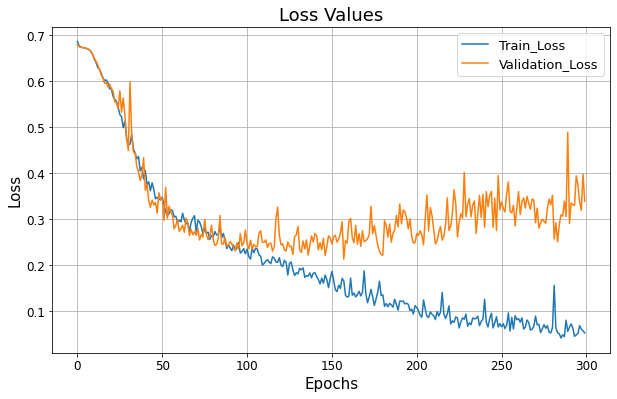

In [20]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train_Loss')
plt.plot(validation_loss, label='Validation_Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=13)
plt.tick_params(labelsize=12)
plt.grid()
plt.title('Loss Values', fontsize=18)
plt.savefig(f'graphs/{version}/loss_b{batch_size}_e{epochs}.png', dpi=300)

### Testing
#### Sample

Truth: person 	 Prediction: person 	 Result: Right


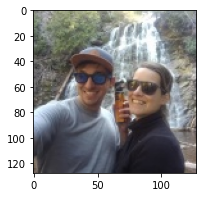

Truth: scene 	 Prediction: scene 	 Result: Right


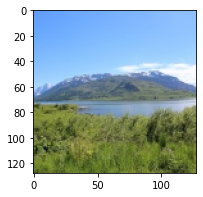

Truth: scene 	 Prediction: scene 	 Result: Right


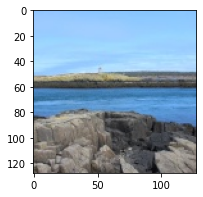

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


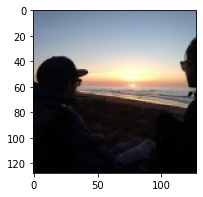

Truth: scene 	 Prediction: scene 	 Result: Right


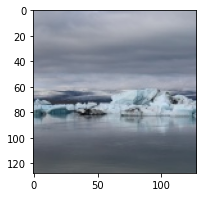

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


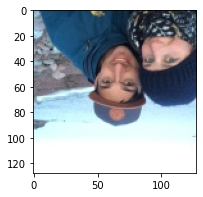

Truth: scene 	 Prediction: scene 	 Result: Right


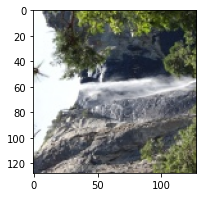

Truth: person 	 Prediction: person 	 Result: Right


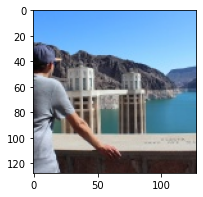

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: scene 	 Prediction: scene 	 Result: Right


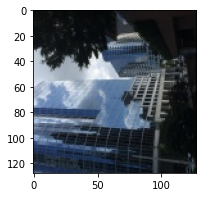

Truth: scene 	 Prediction: scene 	 Result: Right


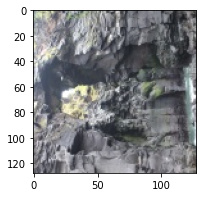

Truth: person 	 Prediction: person 	 Result: Right


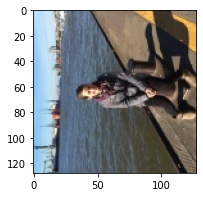

Truth: scene 	 Prediction: scene 	 Result: Right


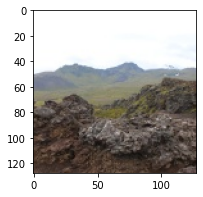

Truth: scene 	 Prediction: person 	 Result: Wrong


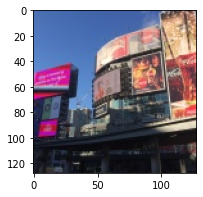

Truth: scene 	 Prediction: scene 	 Result: Right


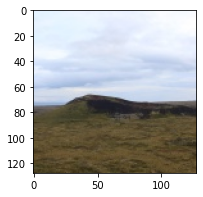

Truth: person 	 Prediction: person 	 Result: Right


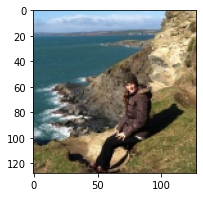

Truth: scene 	 Prediction: scene 	 Result: Right


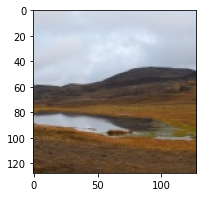

Truth: scene 	 Prediction: scene 	 Result: Right


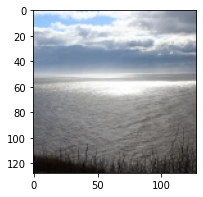

Truth: person 	 Prediction: person 	 Result: Right


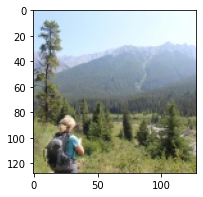

Truth: person 	 Prediction: person 	 Result: Right


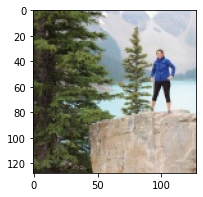

Truth: scene 	 Prediction: scene 	 Result: Right


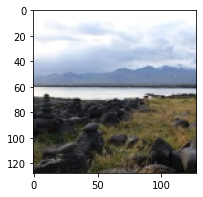

Truth: scene 	 Prediction: scene 	 Result: Right


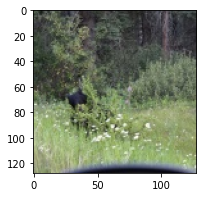

Truth: scene 	 Prediction: scene 	 Result: Right


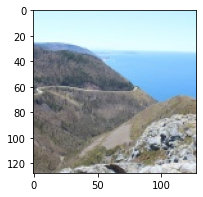

Truth: scene 	 Prediction: scene 	 Result: Right


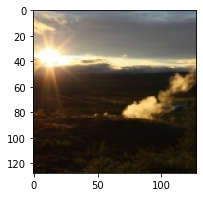

Truth: person 	 Prediction: person 	 Result: Right


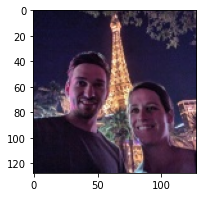

Truth: scene 	 Prediction: scene 	 Result: Right


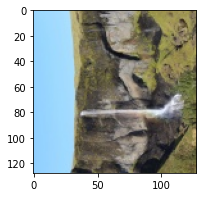

Truth: person 	 Prediction: scene 	 Result: Wrong


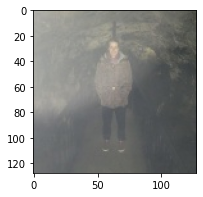

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: scene 	 Result: Wrong


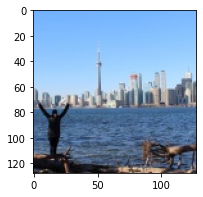

Truth: scene 	 Prediction: scene 	 Result: Right


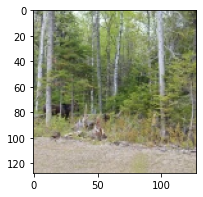

Truth: scene 	 Prediction: scene 	 Result: Right


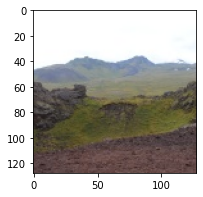

Truth: scene 	 Prediction: scene 	 Result: Right


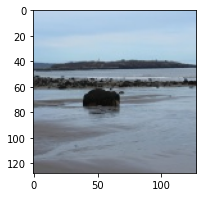

Truth: person 	 Prediction: person 	 Result: Right


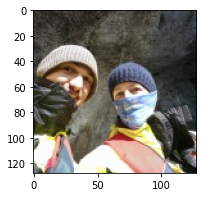

Truth: person 	 Prediction: person 	 Result: Right


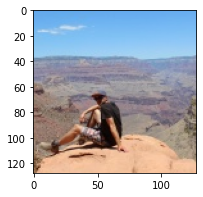

In [21]:
#load a batch from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#generate predictions of testloader samples
#deactivate droptout layer with .eval()
cnn.eval()                 
outputs = cnn(images)

#the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs, 1)

for i in range(batch_size):
    if classes[labels[i]] == classes[predicted[i]]:
        boolean = 'Right'
    else:
        boolean = 'Wrong'
    print(f'Truth: {classes[labels[i]]} \t Prediction: {classes[predicted[i]]} \t Result: {boolean}')
    imshow(images[i])

#### Complete testset - final epoch

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 597 test images: %d %%' % (100 * correct / total),'\n', file=f)
print('Accuracy of the network on the 597 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 597 test images: 92 %


#### Complete testset - best epoch

In [23]:
#Loading the model
cnn_best = CNN(pixel).to(device)
cnn_best.load_state_dict(torch.load(f'models/{version}/cnn_net_b{batch_size}_e{epochs}.pth'))
cnn.eval()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn_best(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = int(100 * correct / total)

print('Accuracy of the network on the 597 test images with best iteration: %d %%' % (100 * correct / total),'\n', file=f)
print('Accuracy of the network on the 597 test images with best iteration: %d %%' % (100 * correct / total))

Accuracy of the network on the 597 test images with best iteration: 89 %


### Script Runtime Result

In [24]:
#End Time of Training
script_end = end_time_()

#Time needed for script
print(f'Execution time of script is : {Execution_time(script_start, script_end)} hh:mm:ss')

Execution time of script is : 00:22:37 hh:mm:ss


### Closing output textfile

In [25]:
f.close()